In [ ]:
#General imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate 

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=15)
#plt.rc('figure', autolayout=True)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=17)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=6)
plt.rc('legend', fontsize=20)
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='STIXGeneral')
#Import cobaya -need to be installed
import cobaya
#Import external loglike from the Likelihood Package within cobaya interface module
from likelihood.cobaya_interface import EuclidLikelihood

In [2]:
#ATTENTION: CHANGE THIS TO YOUR LOCAL PATH where your external codes are installed: CAMB, polychord, likelihoods...
modules_path = "/data2/cobaya_modules/"
h=0.67
# Info is the 'ini file' dictionary. 
# You can translate this info-dictionary into a yaml file and run: cobaya-run info.yaml such as CosmoMC like

info = {
    #Which parameters would you like to sample?
    'params': {
        # Fixed
        'ombh2': 0.022445, 'omch2': 0.12055785610846023, 'H0': 67, 'tau': 0.0925,
        'mnu': 0.06, 'nnu': 2.046, 'omnuh2': 0.00143717*h**2,
        # Sampled - just as an example we assume we will be sampling over ns
        'ns': 0.96, #{'prior': {'min': 0.8, 'max': 1.2}},
        #To be passed to euclid which likelihood to use (preliminary)
        # 1: shear
        # 2: spec
        # 12: both
        'like_selection': 12,
        'As': 2.12605e-9},
    #Which theory code you want to use? HERE CAMB
    'theory': {'camb': {'stop_at_error': True, 'extra_args':{'num_massive_neutrinos': 1}}},
    #Which sample do you want to use? HERE I use MCMC for testing
    'sampler': {'mcmc': None},  
    #Where have you installed your modules (i.e: CAMB, polychord, likelihoods...)
    'packages_path': modules_path,
    #Where are the results going to be stored?
    'output': 'chains/my_euclid_experiment',
    #Likelihood: we load the likelihood as an external function
    'likelihood': {'Euclid': EuclidLikelihood},
    'debug': False,
    'force': True
    }

In [3]:
# Model wrapper of cobaya
from cobaya.model import get_model
model = get_model(info)
model.logposterior({})

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'force']
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB


LogPosterior(logpost=-15.0, logpriors=[0.0], loglikes=array([-15.]), derived=[])

In [4]:
#Import Cosmology module from the Likelihood Package to play with cosmological quantities
from likelihood.cosmo.cosmology import Cosmology
# Some of the theory needs require extra info (redshift, ks)...
z_min = 0.0
z_max = 4.0
z_samp = 100
z_win = np.linspace(z_min, z_max, z_samp)
k_max = 0.2

In [5]:
# Cobaya_interface save the cosmology parameters and the cosmology requirements 
# from CAMB/CLASS via COBAYA to the cosmology class

# This dictionary collects info from cobaya
theory_dic = {'H0': model.provider.get_param('H0'),
                  'omch2': model.provider.get_param('omch2'),
                  'ombh2': model.provider.get_param('ombh2'),
                  'mnu': model.provider.get_param('mnu'),
                  'comov_dist': model.provider.get_comoving_radial_distance(z_win),
                  'angular_dist': model.provider.get_angular_diameter_distance(z_win),
                  'H': model.provider.get_Hubble(z_win),
                  'Pk_interpolator': model.provider.get_Pk_interpolator(nonlinear=False),
                  'Pk_delta': None,
                  'fsigma8': None,
                  'z_win': z_win
                  }
theory_dic['Pk_delta'] = model.provider.get_Pk_interpolator(("delta_tot", "delta_tot"), nonlinear=False)
theory_dic['fsigma8'] = model.provider.get_fsigma8(z_win)
# Remember: h is hard-coded
R, z, sigma_R = model.provider.get_sigma_R()
#print(R)
theory_dic['sigma_8'] = sigma_R[:, 0]

# Initialize cosmology class from likelihood.cosmo.cosmology
# By default: LCDM
cosmology = Cosmology()
cosmology.cosmo_dic.update(theory_dic)
cosmology.update_cosmo_dic(z_win, 0.005)

In [6]:
C_GC = np.genfromtxt("/data2/EUCLID/likelihood-implementation/data/ExternalBenchmark/Photometric/CijGG-LCDM-Lin-noIA.dat")
C_LL = np.genfromtxt("/data2/EUCLID/likelihood-implementation/data/ExternalBenchmark/Photometric/CijLL-LCDM-Lin-noIA.dat")

In [7]:
from likelihood.photometric_survey.shear import Shear
shear = Shear(cosmology.cosmo_dic)

In [12]:
# Save C_GC_11
C_GC_11 = np.zeros(len(C_GC[:200, 0]))
for y, l in enumerate(np.linspace(C_GC[:200, 0][0], C_GC[:200, 0][-1], len(C_GC[:200, 0]))):
    print(l)
    C_GC_11[y]=shear.Cl_GC_phot(l, 1, 1, int_step=0.1)

10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0
105.0
110.0
115.0
120.0
125.0
130.0
135.0
140.0
145.0
150.0
155.0
160.0
165.0
170.0
175.0
180.0
185.0
190.0
195.0
200.0
205.0
210.0
215.0
220.0
225.0
230.0
235.0
240.0
245.0
250.0
255.0
260.0
265.0
270.0
275.0
280.0
285.0
290.0
295.0
300.0
305.0
310.0
315.0
320.0
325.0
330.0
335.0
340.0
345.0
350.0
355.0
360.0
365.0
370.0
375.0
380.0
385.0
390.0
395.0
400.0
405.0
410.0
415.0
420.0
425.0
430.0
435.0
440.0
445.0
450.0
455.0
460.0
465.0
470.0
475.0
480.0
485.0
490.0
495.0
500.0
505.0
510.0
515.0
520.0
525.0
530.0
535.0
540.0
545.0
550.0
555.0
560.0
565.0
570.0
575.0
580.0
585.0
590.0
595.0
600.0
605.0
610.0
615.0
620.0
625.0
630.0
635.0
640.0
645.0
650.0
655.0
660.0
665.0
670.0
675.0
680.0
685.0
690.0
695.0
700.0
705.0
710.0
715.0
720.0
725.0
730.0
735.0
740.0
745.0
750.0
755.0
760.0
765.0
770.0
775.0
780.0
785.0
790.0
795.0
800.0
805.0
810.0
815.0
820.0
825.0
830.0
835.0
840.0
845.0
850.0
855.

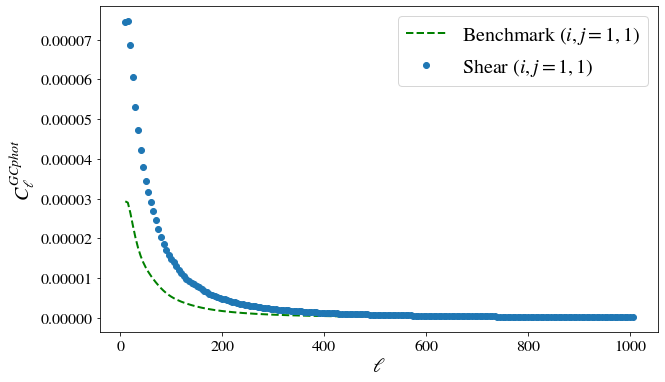

In [13]:
plt.figure(figsize=(10,6));
plt.plot(C_GC[:200, 0], C_GC[:200, 1], 'g--', label=r"Benchmark $(i,j=1,1)$")
plt.plot(C_GC[:200, 0], C_GC_11, 'o', label="Shear $(i,j=1,1)$")
plt.xlabel(r"$\ell$", fontsize=20);
plt.ylabel(r"$C_\ell^{GCphot}$", fontsize=20);
plt.legend()
#plt.plot(C_GC[:200, 0], C_GC_11, 'o')

In [ ]:
plt.figure(figsize=(10,6));
plt.plot(C_GC[:200, 0], C_GC_11, 'o', label="Shear $(i,j=1,1)$")
plt.xlabel(r"$\ell$", fontsize=20);
plt.ylabel(r"$C_\ell^{GCphot}$", fontsize=20);
plt.legend()
#plt.plot(C_GC[:200, 0], C_GC_11, 'o')

In [ ]:
# Save C_GC_11
C_LL_11 = np.zeros(len(C_LL[:200, 0]))
for y, l in enumerate(np.linspace(C_LL[:200, 0][0], C_LL[:200, 0][-1], len(C_LL[:200, 0]))):
    print(l)
    C_LL_11[y]=shear.Cl_WL(l, 1, 1, int_step=0.1)

In [ ]:
plt.figure(figsize=(10,6));
plt.semilogx(C_LL[:200, 0], C_LL[:200, 1], 'g--', label=r"Benchmark $(i,j=1,1)$")
plt.semilogx(C_LL[:200, 0], C_LL_11, 'o', label="Shear $(i,j=1,1)$")
plt.xlabel(r"$\ell$", fontsize=20);
plt.ylabel(r"$C_\ell^{WL}$", fontsize=20);
plt.legend()
#plt.plot(C_GC[:200, 0], C_GC_11, 'o')

In [14]:
shear.Cl_GC_phot(10.0, 1, 1)

7.437569110546929e-05